In [1]:
'''Implementation of PMCMC to test on the OU Process'''

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from particle_filter import filter
from models import OU_model,OU_Obs
from pmcmc import PMCMC
from scipy.stats import norm,gamma,uniform,expon

In [2]:
rng = np.random.default_rng(0)

'''Generate an example dataset to perform inference on'''
lam = 1/10
m = 2. 
sig_x = 0.5
sig_y = 0.5

t_initial = 0
dt = 0.1
t_final = 300+dt
t_vector = np.arange(t_initial, t_final, dt).T

x_vector = np.zeros(len(t_vector))
x_vector[0] = 0.5

dW = np.sqrt(dt) * rng.normal(size=(len(t_vector - 1),))
for t in range(1,len(t_vector)): 
    x_vector[t] = x_vector[t-1] - lam * (x_vector[t-1] - m) * dt + np.sqrt(2 * lam) * sig_x * dW[t]

data = x_vector[::int(1/dt)] #data for PF, the real component of the simulated process

data = data + rng.normal(0.,sig_y,size = (len(data)))

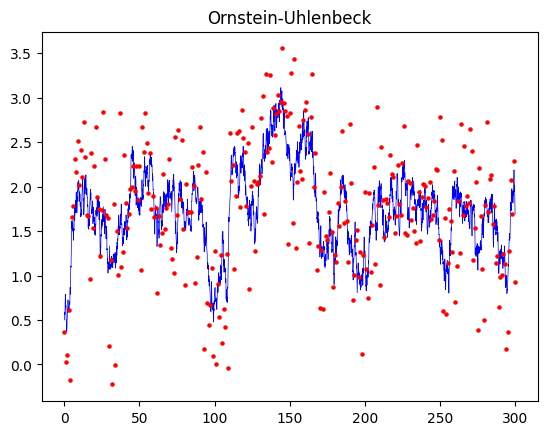

In [3]:
plt.title("Ornstein-Uhlenbeck")
plt.plot(t_vector, x_vector,color = 'blue',lw = 0.5)
plt.scatter(t_vector[::int(1/dt)],data,color = 'red',zorder = 12,s= 5.)
plt.show()

In [4]:

particles, weights,_ = filter(data = data,
                              theta= (lam,m,sig_x,sig_y),
                              rng = rng,num_particles = 1000,
                              dt = dt,
                              model = OU_model,
                              observation=OU_Obs,
                              model_dim = 1,
                              observation_dim=1)


ValueError: could not broadcast input array from shape (4,) into shape (1000,1)

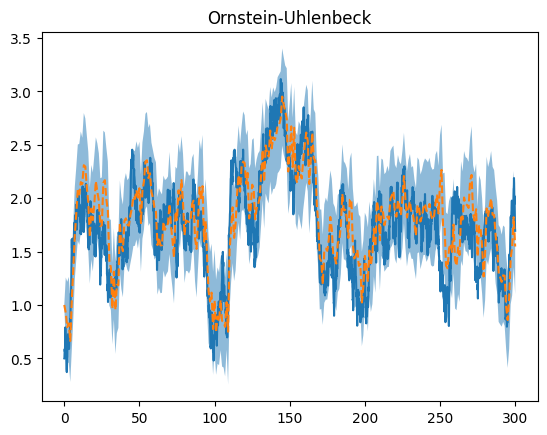

In [ ]:
plt.title("Ornstein-Uhlenbeck")

plt.plot(t_vector, np.real(x_vector))
plt.plot(t_vector[::int(1/dt)],np.average(particles[:,0,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,0,:],5,axis = 0),np.percentile(particles[:,0,:],95,axis = 0),alpha = 0.5)
plt.show()



In [ ]:
iterations = 10000

num_particles = 1000

prior = lambda x: expon.logpdf(x =(x[0]), scale = 5.) +\
     norm.logpdf(x = x[1], scale = 50.) + \
        expon.logpdf(x = x[2],scale = 5.) + \
                expon.logpdf(x = x[2],scale = 5.)

theta, LL, pf_means = PMCMC(iterations=iterations,
                  num_particles=num_particles,
                  init_theta=np.array([1.,2.,1.,1.]),
                  data = data,
                  rng = rng,
                  dt = dt, 
                  prior = prior, 
                  model = OU_model,
                  observation = OU_Obs,
                  model_dim=1)





iteration: 10| Acceptance rate: 0.3| Log-Likelihood: -341.45779054457324
iteration: 20| Acceptance rate: 0.35| Log-Likelihood: -316.8429344761657
iteration: 30| Acceptance rate: 0.3| Log-Likelihood: -302.9444575643855
iteration: 40| Acceptance rate: 0.275| Log-Likelihood: -304.25769763357476
iteration: 50| Acceptance rate: 0.3| Log-Likelihood: -303.7716135438819
iteration: 60| Acceptance rate: 0.26666666666666666| Log-Likelihood: -302.651702393292
iteration: 70| Acceptance rate: 0.2857142857142857| Log-Likelihood: -302.58129028584386
iteration: 80| Acceptance rate: 0.375| Log-Likelihood: -304.9070428579858
iteration: 90| Acceptance rate: 0.43333333333333335| Log-Likelihood: -303.1141335895318
iteration: 100| Acceptance rate: 0.42| Log-Likelihood: -306.25643854045956
iteration: 110| Acceptance rate: 0.43636363636363634| Log-Likelihood: -302.83973858368694
iteration: 120| Acceptance rate: 0.45| Log-Likelihood: -303.51846872087486
iteration: 130| Acceptance rate: 0.4307692307692308| Log-L

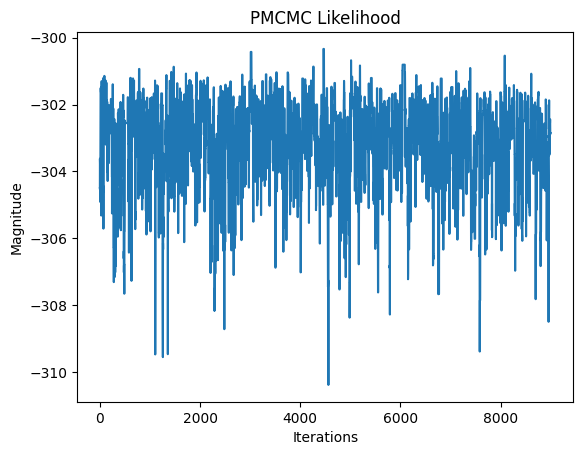

In [ ]:
burn_in = int(iterations/10)

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(LL[burn_in:])

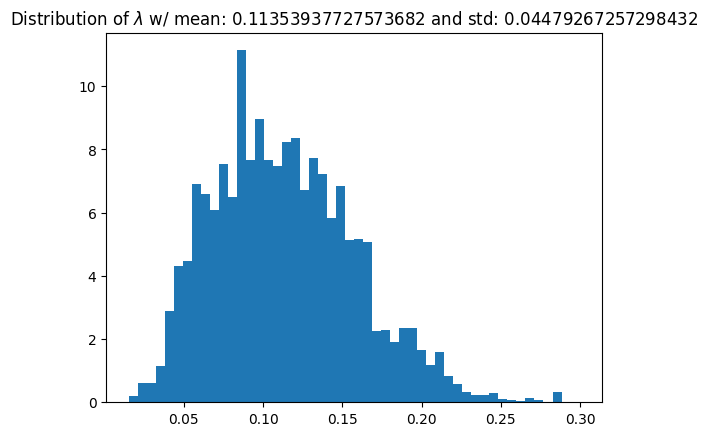

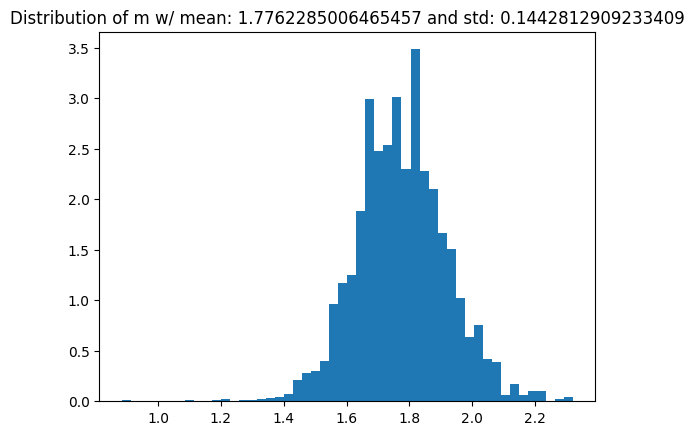

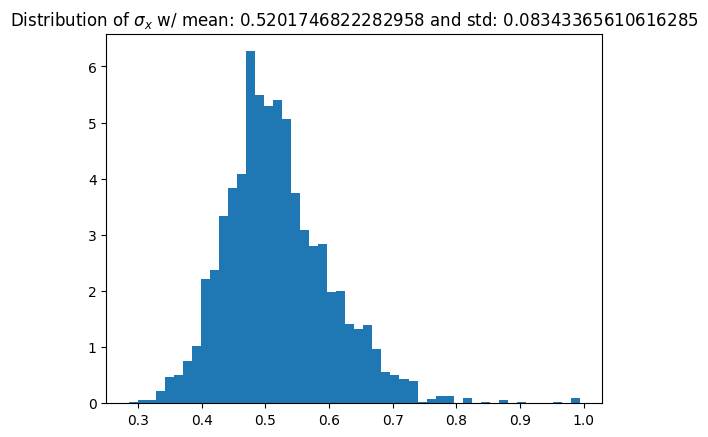

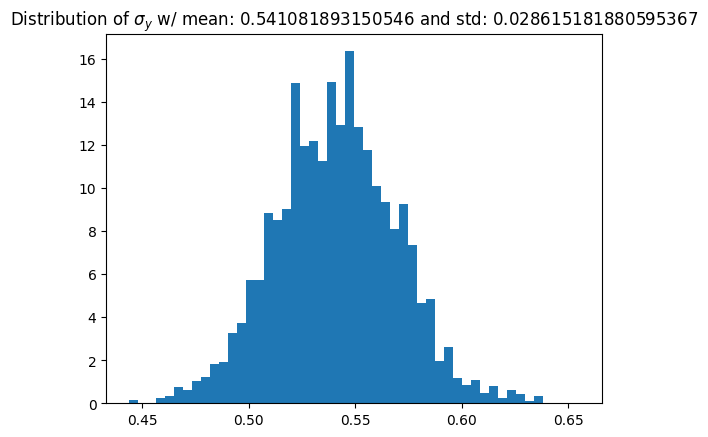

In [ ]:


plt.title(f"Distribution of $\\lambda$ w/ mean: {np.mean(theta[0,burn_in:])} and std: {np.std(theta[0,burn_in:])}")
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of m w/ mean: {np.mean((theta[1,burn_in:]))} and std: {np.std((theta[1,burn_in:]))}")
plt.hist((theta[1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\sigma_x$ w/ mean: {np.mean(theta[2,burn_in:])} and std: {np.std(theta[2,burn_in:])}")
plt.hist(theta[2,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\sigma_y$ w/ mean: {np.mean(theta[3,burn_in:])} and std: {np.std(theta[3,burn_in:])}")
plt.hist(theta[3,burn_in:],density=True,bins = 50)
plt.show()


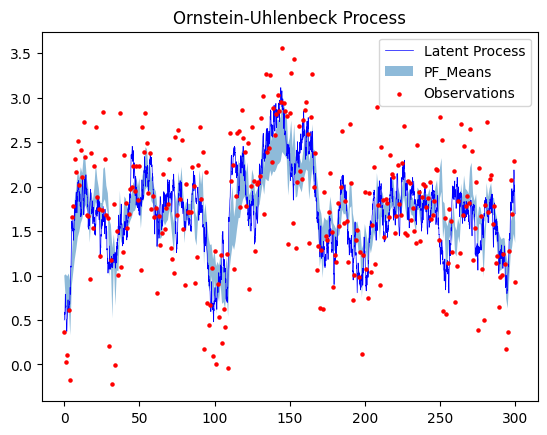

In [ ]:
plt.title("Ornstein-Uhlenbeck Process")
plt.plot(t_vector, x_vector,color = 'blue',lw = 0.5,label = 'Latent Process')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(pf_means[0,:,:],5,axis = 1),np.percentile(pf_means[0,:,:],95,axis = 1),alpha = 0.5,label = 'PF_Means')
plt.scatter(t_vector[::int(1/dt)],data,color = 'red',zorder = 12,s= 5.,label = 'Observations')
plt.legend()
plt.show()